<a href="https://colab.research.google.com/github/jannat99/ML/blob/main/Assignment_1_170204051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from numpy.lib.function_base import append
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Import Dataset**

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/dataset/Dataset.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


# **Split Train-Test Data**

In [ ]:
seed = 170204051
torch.manual_seed(seed)
df = df.sample(frac = 1)
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=seed)

# **Clean Data**

In [ ]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
stopwordSet=set(stopwords.words('english'))

df['Text'] = df['Text'].apply(lambda x: x.lower())
df['Text'] = df['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['Text'] = df['Text'].apply((lambda x: re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",'',x)))
df['Text'] = df['Text'].apply((lambda x: re.sub('@[^\s]+','',x)))

def process_text(text):
    tokens = word_tokenize(text)
    final_tokens = [w for w in tokens if w not in stopwordSet]
    ps = PorterStemmer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = ps.stem(w)
        finalwords.append(word)
    return ' '.join(finalwords)
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))

# **Feature Selection - BoW**

In [ ]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

# **Model - Neural Network**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 256) 
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()       
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_4(x)
        logits = self.sigmoid(x)
        return logits
model = NeuralNetwork(len(df))

# **Accuracy, Precision, Recall, F1-score**

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()
    batch = 256
    size = X_test.shape[0]
    loss = 0
    acc = 0
    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)              
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()  
    loss /= size
    acc /= size
    return loss, acc

In [ ]:
epochs = 3
best_valid_loss = float('inf')
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
for epoch in range(epochs):
    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.645 |  Val. Acc: 64.54%

	Train Loss: 0.012 | Train Acc: 1.21%
	 Val. Loss: 0.580 |  Val. Acc: 64.54%

	Train Loss: 0.012 | Train Acc: 1.21%
	 Val. Loss: 0.558 |  Val. Acc: 64.54%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

acc=(TP+TN)/(TP+TN+FN+FP)
prec=TP/(TP+FP)
rec=TP/(TP+FN)
f1score=2*prec*rec/(prec+rec)
print(f'\tAccuracy | Precision | Recall | F1score')
print(f'\t---------|-----------|--------|--------')
print(f'\t{acc:.6f} | {prec:.6f}  | {rec:.4f} | {f1score:.4f}')

	Accuracy | Precision | Recall | F1score
	---------|-----------|--------|--------
	0.741731 | 0.760651  | 0.8752 | 0.8139


# **Feature Selection - TFIDF**

In [ ]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)
X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Model - Neural Network**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 256) 
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()       
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_4(x)
        logits = self.sigmoid(x)
        return logits
model = NeuralNetwork(len(df))

# **Accuracy, Precision, Recall, F1-score**

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()
    batch = 256
    size = X_test.shape[0]
    loss = 0
    acc = 0
    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)              
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()  
    loss /= size
    acc /= size
    return loss, acc

In [ ]:
epochs = 3
best_valid_loss = float('inf')
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
for epoch in range(epochs):
    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.646 |  Val. Acc: 64.54%

	Train Loss: 0.012 | Train Acc: 1.21%
	 Val. Loss: 0.582 |  Val. Acc: 64.54%

	Train Loss: 0.012 | Train Acc: 1.21%
	 Val. Loss: 0.563 |  Val. Acc: 64.54%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

acc=(TP+TN)/(TP+TN+FN+FP)
prec=TP/(TP+FP)
rec=TP/(TP+FN)
f1score=2*prec*rec/(prec+rec)
print(f'\tAccuracy | Precision | Recall | F1score')
print(f'\t---------|-----------|--------|--------')
print(f'\t{acc:.6f} | {prec:.6f}  | {rec:.4f} | {f1score:.4f}')

	Accuracy | Precision | Recall | F1score
	---------|-----------|--------|--------
	0.759275 | 0.778393  | 0.8766 | 0.8246


# **One hot embedding & CNN**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
Xcnn_train = tokenizer.texts_to_sequences(text_train)
Xcnn_test = tokenizer.texts_to_sequences(text_test)
vocab_size = len(tokenizer.word_index)+1
print(text_train[1])
print(Xcnn_train[1]) 

CVT TECHNICA TADES WATCH IST tonight. These 20 stocks have the good characteristics with the market being strong.  
[4026, 1574, 1575, 53, 497, 755, 251, 94, 97, 59, 1, 42, 1223, 24, 1, 63, 351, 159]


In [ ]:
maxlen = 150
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[  14 1573   10 1828    7    8  539  414 2835  126 4024   15  997  169
  127   38   43  540 4025    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 200)          1811200   
                                                                 
 conv1d_3 (Conv1D)           (None, 149, 256)          102656    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 74, 256)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 72, 128)           98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 33, 64)           

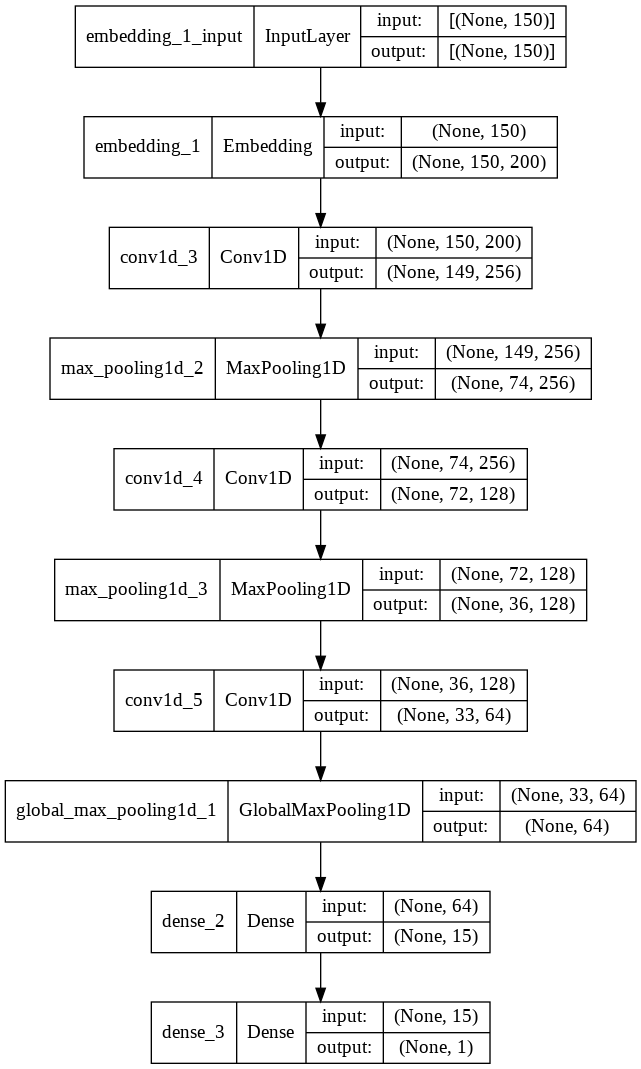

In [ ]:
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(15, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)

# **Error Curve Against Epochs**

In [ ]:
history = textcnnmodel.fit(Xcnn_train, label_train, epochs=20, verbose=True, validation_data=(Xcnn_test, label_test), batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
464/464 [==============================] - 39s 82ms/step - loss: -115791.8281 - accuracy: 0.1699 - val_loss: -797918.1250 - val_accuracy: 0.2934
Epoch 2/20
464/464 [==============================] - 36s 77ms/step - loss: -55792672.0000 - accuracy: 0.2712 - val_loss: -152331488.0000 - val_accuracy: 0.2623
Epoch 3/20
464/464 [==============================] - 36s 78ms/step - loss: -1500587136.0000 - accuracy: 0.2791 - val_loss: -2457736448.0000 - val_accuracy: 0.2416
Epoch 4/20
464/464 [==============================] - 38s 81ms/step - loss: -12548748288.0000 - accuracy: 0.2873 - val_loss: -14878970880.0000 - val_accuracy: 0.2407
Epoch 5/20
464/464 [==============================] - 35s 75ms/step - loss: -56074153984.0000 - accuracy: 0.2848 - val_loss: -53146324992.0000 - val_accuracy: 0.0595
Epoch 6/20
464/464 [==============================] - 35s 76ms/step - loss: -170337353728.0000 - accuracy: 0.2884 - val_loss: -143219998720.0000 - val_accuracy: 0.2381
Epoch 7/20
464/464 

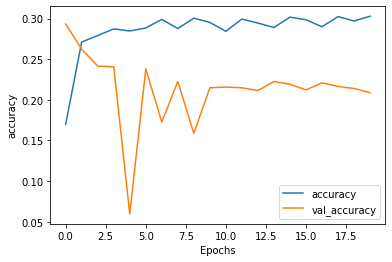

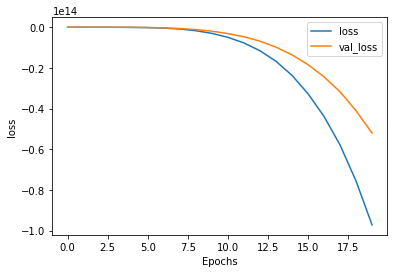

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# **Confusion Matrix**

In [ ]:
y_pred = textcnnmodel.predict(Xcnn_train)
y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 5s 33ms/step - loss: -110761426812928.0000 - accuracy: 0.3066


In [ ]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(label_train, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -110761426812928.0
Train Accuracy: 0.30656304955482483 (Model Metric)
Train Accuracy: 0.663860103626943 (sklearn Metric)
Train Precision: 0.9726027397260274
Train Recall: 0.48348655090228126
Train F1-score: 0.6458949283602456


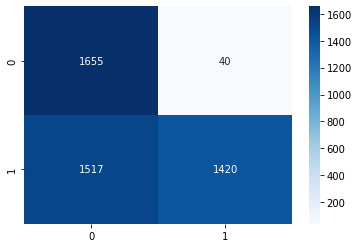

In [ ]:
sns.heatmap(confusion_matrix(label_train, y_pred), annot = True, fmt = 'g', cmap='Blues')

In [ ]:
y_pred = textcnnmodel.predict(Xcnn_test)
y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

Test Accuracy: 0.545297670405522 (sklearn Metric)


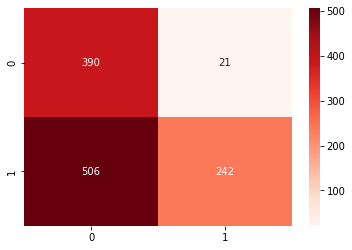

In [ ]:
print('Test Accuracy:', accuracy_score(label_test, y_pred), '(sklearn Metric)')
sns.heatmap(confusion_matrix(label_test, y_pred), annot = True, fmt = 'g', cmap='Reds')